In [1]:
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


# function for visualizing data
def simple_plot_image(image, title):
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.title(title)

In [2]:
dataset_path = '../data/videos'
video_idxes = os.listdir(dataset_path)
video_idxes.remove('Info.txt')
video_idxes.remove('Info.txt~')

# using videos-level train-test split
train_video_idxes, test_video_idxes = train_test_split(video_idxes, train_size=0.66)

TRAIN_TIME_STEPS = 9
TRAIN_TIME_STEPS_BEFORE_FRAME = TRAIN_TIME_STEPS // 2
TRAIN_TIME_STEPS_AFTER_FRAME = TRAIN_TIME_STEPS // 2

In [4]:
# will keep all train data in memory bc
Y_train_group_LSTM = []
X_train_individual_LSTM_unprocessed = []
Y_train_individual_LSTM = []

test_counter=1
for video_idx in train_video_idxes:
    # todo remove this
    if test_counter==0:
        break
    test_counter-=1
    # end remove section
    
    annotations = open(f"{dataset_path}/{video_idx}/annotations.txt", 'r').readlines()
    for frame_annotation in annotations:
        main_frame_file_name, group_activity_name, *player_annotations = frame_annotation.strip().split(' ')
        Y_train_group_LSTM.append(group_activity_name)

        while len(player_annotations) != 0:
            x_annotation, y_annotation, width_annotation, height_annotation, individual_activity_name, *player_annotations = player_annotations
            x_annotation = int(x_annotation)
            y_annotation = int(y_annotation)
            width_annotation = int(width_annotation)
            height_annotation = int(height_annotation)

            Y_train_individual_LSTM.append(individual_activity_name)

            individual_tracklet = []
            main_frame_id, _ = main_frame_file_name.split('.')
            main_frame_id = int(main_frame_id)
            training_frames_path = [f"{dataset_path}/{video_idx}/{main_frame_id}/{i}.jpg" for i in
                                    range(main_frame_id - TRAIN_TIME_STEPS_BEFORE_FRAME,
                                          main_frame_id + TRAIN_TIME_STEPS_AFTER_FRAME + 1)]
            for training_frame_path in training_frames_path:
                frame = np.asarray(Image.open(training_frame_path))
                cropped_frame = tf.image.crop_to_bounding_box(frame, y_annotation, x_annotation, height_annotation,
                                                              width_annotation)

                individual_tracklet.append(cropped_frame)

            X_train_individual_LSTM_unprocessed.append(individual_tracklet)

Getting some statistics of data:

Note: annotation error in some files, for example video index: 44, frame index: 40750.jpg
whitespace at the end of line, will use frame_annotation.strip().split(' ')

In [5]:
all_width_annotations = []
all_height_annotations = []
all_group_activity_annotations = set()
all_individual_activity_annotations = set()
for video_idx in video_idxes:
    annotations = open(f"{dataset_path}/{video_idx}/annotations.txt", 'r').readlines()
    for frame_annotation in annotations:
        main_frame_file_name, group_activity_name, *player_annotations = frame_annotation.strip().split(' ')
        all_group_activity_annotations.add(group_activity_name)

        while len(player_annotations) != 0:
            _, _, width_annotation, height_annotation, individual_activity_name, *player_annotations = player_annotations
            all_individual_activity_annotations.add(individual_activity_name)
            width_annotation = int(width_annotation)
            height_annotation = int(height_annotation)
            all_width_annotations.append(width_annotation)
            all_height_annotations.append(height_annotation)

print(f"max annotated width: {max(all_width_annotations)}; max annotated height: {max(all_height_annotations)}")
print(f"30th percentile of annotated widths: {np.percentile(all_width_annotations, 30)}")
print(f"distinct group activity annotations: {all_group_activity_annotations}")
print(f"distinct individual activity annotations: {all_individual_activity_annotations}")

max annotated width: 221; max annotated height: 323
30th percentile of annotated widths: 46.0
distinct group activity annotations: {'r_winpoint', 'l_set', 'r_spike', 'r_set', 'l-pass', 'l_winpoint', 'r-pass', 'l-spike'}
distinct individual activity annotations: {'falling', 'moving', 'blocking', 'waiting', 'digging', 'spiking', 'setting', 'standing', 'jumping'}


## Decision on resizing images

It is a good choice to downsize images to the smallest image. The xception models needs inputs of shape at least (71*71*3).

<sub><sup>TODO: research and implement better options, links:
https://blog.roboflow.com/you-might-be-resizing-your-images-incorrectly/
https://keras.io/examples/vision/learnable_resizer/
https://zuru.tech/blog/the-dangers-behind-image-resizing
https://medium.com/neuronio/how-to-deal-with-image-resizing-in-deep-learning-e5177fad7d89</sup></sub>

In [6]:
XCEPTION_MIN_ACCEPTABLE_DIMENSION = 71
XCEPTION_resize_width = max(XCEPTION_MIN_ACCEPTABLE_DIMENSION, min(all_width_annotations))
XCEPTION_resize_height = max(XCEPTION_MIN_ACCEPTABLE_DIMENSION, min(all_height_annotations))

## Decision on encoding categorical labels

I use one-hot encoding, since there is no ordinal arrangement in specified activities

In [7]:
group_activity_map = tf.keras.layers.StringLookup(vocabulary=list(all_group_activity_annotations), output_mode='one_hot')
group_activity_inverse_map = tf.keras.layers.StringLookup(vocabulary=list(all_group_activity_annotations), invert=True)
individual_activity_map = tf.keras.layers.StringLookup(vocabulary=list(all_individual_activity_annotations), output_mode='one_hot')
individual_activity_inverse_map = tf.keras.layers.StringLookup(vocabulary=list(all_individual_activity_annotations), invert=True)

Y_train_individual_LSTM = individual_activity_map(Y_train_individual_LSTM)
Y_train_group_LSTM = group_activity_map(Y_train_group_LSTM)

Preprocessing of images done by layers that are included in the model (i.e. the xception model), in an end-to-end fashion
Advantage: it will benefit from GPU acceleration.
https://www.tensorflow.org/guide/keras/preprocessing_layers#preprocessing_data_before_the_model_or_inside_the_model

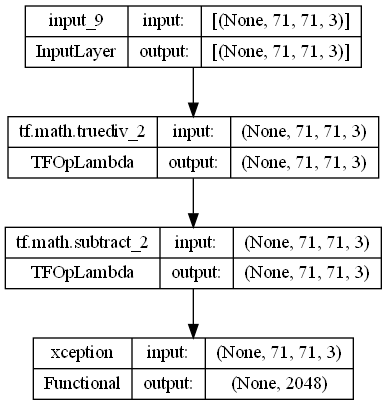

In [14]:
frame_inputs = tf.keras.Input(shape=(71, 71, 3))
# frame_inputs = tf.keras.Input(shape=(None, None, 3))
# preprocessed_inputs = tf.keras.layers.Resizing(XCEPTION_resize_height, XCEPTION_resize_width)(frame_inputs)
# preprocessed_inputs = tf.keras.applications.xception.preprocess_input(preprocessed_inputs)
preprocessed_inputs = tf.keras.applications.xception.preprocess_input(frame_inputs)
xception_model = tf.keras.applications.Xception(weights='imagenet', input_shape=preprocessed_inputs.shape[1:], include_top=False, pooling='avg')
xception_model.trainable = False
xception_features = xception_model(preprocessed_inputs, training=False)
preprocess_and_xception = tf.keras.Model(inputs=frame_inputs, outputs=xception_features, name="preprocess_and_xception")

# tf.keras.utils.plot_model(preprocess_and_xception, "preprocess_and_xception.png", show_shapes=True)

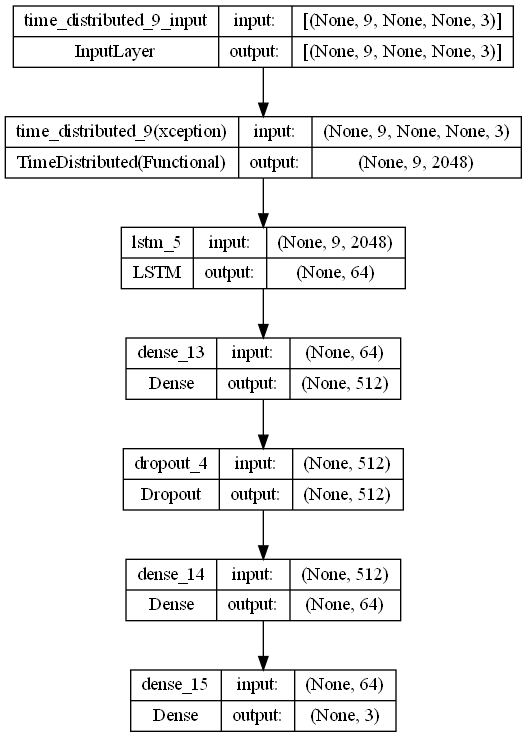

In [24]:
# class XceptionOnTimeSteps(tf.keras.layers.Layer):
#   def __init__(self, input_shape):
#       super(XceptionOnTimeSteps, self).__init__()
#       assert len(input_shape) == 4
#       assert input_shape[-1] == 3
#       self.trainable=False
#       self.preprocess_and_xception = preprocess_and_xception
#       # xception_features_shape is expected to be 0-rank and equal to 2048
#       self.xception_features_shape = self.preprocess_and_xception.outputs[0].shape[-1]
# 
#   def call(self, inputs):
#       # todo delete this later
#       print(f"log in XceptionOnTimeSteps. input shape on call: {inputs.shape}")
#       
#       self.total.assign_add(tf.reduce_sum(inputs, axis=0))
#       return self.total

from keras.layers import TimeDistributed, LSTM, Dense, Dropout

def build_mobilenet(shape, nbout=3):
    preprocessed_inputs1 = tf.keras.applications.xception.preprocess_input
    model1=tf.keras.applications.Xception(weights='imagenet', input_shape=shape, include_top=False, pooling='avg')
    model1.trainable = False
    return model1
    # return keras.Sequential([preprocessed_inputs1, model1])

def action_model(shape=(9, None, None, 3), nbout=3):
    convnet = build_mobilenet(shape[1:])
    
    # then create our final model
    model = keras.Sequential()
    model.add(TimeDistributed(convnet, input_shape=shape))
    # here, you can also use GRU or LSTM
    model.add(LSTM(64))
    # and finally, we make a decision network
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='softmax'))
    return model


model = action_model()

tf.keras.utils.plot_model(model, "test lstm.png", show_shapes=True)

In [15]:
import keras

# individual_tracklet_inputs = tf.keras.Input(shape=(TRAIN_TIME_STEPS, None, None, 3))
individual_tracklet_inputs = tf.keras.Input(shape=(TRAIN_TIME_STEPS, 71, 71, 3))
# xception_features_shape is expected to be 0-rank and equal to 2048
# xception_features_shape = preprocess_and_xception.outputs[0].shape[-1]
# 
# individual_tracklet_xception_features = tf.keras.layers.Lambda(
#     lambda x: tf.reshape(preprocess_and_xception(tf.reshape(x, [-1, 71, 71, 3])),
#                          [-1, TRAIN_TIME_STEPS, xception_features_shape]),
#     input_shape=individual_tracklet_inputs.shape[1:])
# individual_tracklet_xception_features=individual_tracklet_xception_features(individual_tracklet_inputs)
# TimeDistributed does not work in tf=2.10; used lambda layer instead; https://stackoverflow.com/questions/59970196/timedistributed-of-a-keraslayer-in-tensorflow-2-0
individual_tracklet_xception_features = keras.layers.TimeDistributed(preprocess_and_xception, input_shape=individual_tracklet_inputs[1:])
individual_tracklet_xception_features = individual_tracklet_xception_features(individual_tracklet_inputs)


x = tf.keras.layers.LSTM(3000)(individual_tracklet_xception_features)
# todo change categorical conversoin to to without oov
individual_activity_softmax = tf.keras.layers.Dense(9, activation='softmax')(x)

individual_lstm_model = tf.keras.Model(inputs=individual_tracklet_inputs, outputs=individual_activity_softmax, name="individual_lstm_model")

# todo decide: what frame to choose from xception_features for frame level aggregate feature? all/main frame
person_representation = tf.keras.layers.Concatenate()([xception_features, individual_lstm_model.outputs])
# # pooling of all persons or persons of one group
# # TODO data_format channels first or last?
# # TODO what pooling layer to use? https://keras.io/api/layers/pooling_layers/
# group_pool_layer = tf.keras.layers.AveragePooling1D(pool_size=, strides=, padding="valid", data_format=None,
#                                                     name="group_pool_layer")(person_representation)
# # aggregate into fc layer then fed into 2nd lstm
# x = tf.keras.layers.Dense(3000)(group_pool_layer)
# # todo how to define 9 timesteps here?
# x = tf.keras.layers.LSTM(500)(x)
# group_activity_softmax = tf.keras.layers.Dense(8, activation='softmax')(x)
# 
# # todo have i choosed model input correctly?
# group_lstm_model = tf.keras.Model(inputs=x, outputs=group_activity_softmax, name="group_lstm_model")
# 
# hierarchical_lstm_model = tf.keras.Model(inputs=individual_tracklet_inputs, outputs=group_lstm_model.outputs,
#                                          name="hierarchical_lstm_model")
# tf.keras.utils.plot_model(hierarchical_lstm_model, "hierarchical lstm.png", show_shapes=True)
# 
# # TODO maybe fine tune xception
# # todo specify learning rate 0.00001 and momentum 0.9
# # maybe this # we use SGD with a low learning rate from keras.optimizers import SGD model.compile(optimizer=SGD(lr=0.0001, momentum=0.9)
# optimizer = keras.optimizers.Adam(0.001)
# model.compile(
#     optimizer,
#     'categorical_crossentropy',
#     metrics=['acc']
# )
# individual_lstm_model.compile(tbd)
# # can use validation_split here
# individual_lstm_model.fit(tbd)
# 
# group_lstm_model.compile(tbd)
# group_lstm_model.fit(tbd)

NotImplementedError: Exception encountered when calling layer "time_distributed_2" (type TimeDistributed).

Please run in eager mode or implement the `compute_output_shape` method on your layer (TFOpLambda).

Call arguments received by layer "time_distributed_2" (type TimeDistributed):
  • inputs=tf.Tensor(shape=(None, 9, 71, 71, 3), dtype=float32)
  • training=False
  • mask=None

In [ ]:
# todo test
# copy for reading test data later, optional delete train data from memory